# Simple analysis of GP1900

TODO:

- [ ] Histogram 2D using geopandas
- [ ] Legend beautification
- [ ] local_authority labels on the maps (when hover over them)
- [ ] set max/min colors for colormap (it seems it is set to white now)
- [ ] change basemap to exclude Northern Ireland
- [ ] query maps based on lat/lon of pins, possibly add a new column with link to sheets
- [ ] abbreviation disambiguation 

In [1]:
# %matplotlib notebook 

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

with open("./gb1900_gazetteer_complete_july_2018.csv", encoding='UTF-16') as f:
    df = pd.read_csv(f)

/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
df.head()

,pin_id,final_text,nation,local_authority,parish,osgb_east,osgb_north,latitude,longitude,notes
0,52b34d8b695fe90005004e1e,F. P.,Wales,Powys,Llansilin,320836.712742,327820.182715,52.842050,-3.176744,NaN
1,5800a6b92c66dcab3d061796,Parly. & Munl Boro. By.,England,City of London,NaN,531794.825962,180705.741898,51.509918,-0.102246,NaN
2,5800a6782c66dcab3d061786,S. Ps.,England,City of London,NaN,531736.217116,180725.027730,51.510105,-0.103083,NaN
3,57f684f42c66dcab3d01c0dd,Southwark Bridge Stairs,England,City of London,NaN,532199.584123,180696.934434,51.509744,-0.096420,NaN
4,57f685002c66dcab3d01c0e9,St. Paul's Pier,England,City of London,NaN,531987.486097,180745.664556,51.510232,-0.099456,NaN


Total number of unique text strings: 692648
Number of unique text strings (after filtering): 30


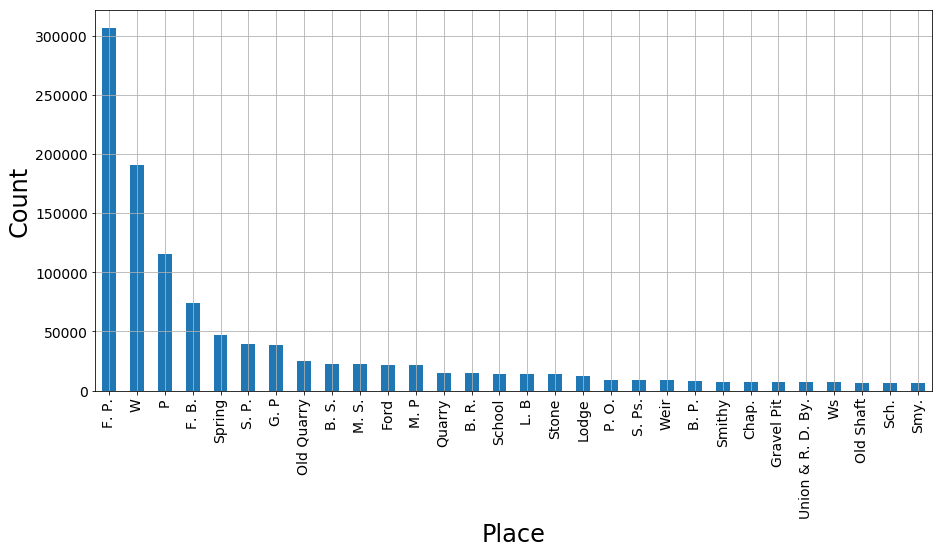

In [4]:
min_counts = 5000
xy2plot = df.groupby("final_text").count().sort_values("pin_id", ascending=False)["pin_id"]
xy2plot_filtered = xy2plot[xy2plot > min_counts]
print("Total number of unique text strings: {}".format(len(xy2plot)))
print("Number of unique text strings (after filtering): {}".format(len(xy2plot_filtered)))

ax = plt.figure(figsize=(15, 7)).add_subplot(111)
xy2plot_filtered.plot(ax=ax, kind='bar')
ax.set_xlabel("Place", size=24)
ax.set_ylabel("Count", size=24)
ax.tick_params(labelsize=14)
ax.grid()
plt.show()

In [19]:
first_index = 0
last_index = 50
xy2plot_filtered[first_index:last_index]

final_text
F. P.                306583
W                    190979
P                    115877
F. B.                 74514
Spring                46876
S. P.                 39571
G. P                  38842
Old Quarry            24673
B. S.                 22363
M. S.                 22161
Ford                  21926
M. P                  21241
Quarry                15042
B. R.                 14891
School                14351
L. B                  14279
Stone                 13625
Lodge                 12661
P. O.                  9030
S. Ps.                 8841
Weir                   8840
B. P.                  8528
Smithy                 7330
Chap.                  7177
Gravel Pit             7029
Union & R. D. By.      6887
Ws                     6868
Old Shaft              6436
Sch.                   6422
Smy.                   6189
Name: pin_id, dtype: int64

In [22]:
df

,pin_id,final_text,nation,local_authority,parish,osgb_east,osgb_north,latitude,longitude,notes
0,52b34d8b695fe90005004e1e,F. P.,Wales,Powys,Llansilin,320836.712742,327820.182715,52.842050,-3.176744,NaN
1,5800a6b92c66dcab3d061796,Parly. & Munl Boro. By.,England,City of London,NaN,531794.825962,180705.741898,51.509918,-0.102246,NaN
2,5800a6782c66dcab3d061786,S. Ps.,England,City of London,NaN,531736.217116,180725.027730,51.510105,-0.103083,NaN
3,57f684f42c66dcab3d01c0dd,Southwark Bridge Stairs,England,City of London,NaN,532199.584123,180696.934434,51.509744,-0.096420,NaN
4,57f685002c66dcab3d01c0e9,St. Paul's Pier,England,City of London,NaN,531987.486097,180745.664556,51.510232,-0.099456,NaN
5,59eb8cae2c66dc79120026d6,Pier,England,City of London,NaN,531647.214047,180767.304005,51.510505,-0.104349,NaN
6,57f00e9e2c66dca322010ab4,Landing Place,England,Southwark,NaN,531537.695456,180566.073891,51.508722,-0.106001,NaN
7,57f3c17e2c66dcab3d00984c,Landing Stages,England,Lambeth,NaN,531307.416393,180540.056952,51.508542,-0.109327,NaN
8,57e526222c66dc43f4000dcd,New Scotland Yard,England,Westminster,NaN,530369.099820,179827.783170,51.502358,-0.123103,NaN
9,57e55bd82c66dc43f4001ee8,ST. THOMAS'S HOSPITAL,England,Westminster,NaN,530421.850835,179456.055706,51.499006,-0.122480,NaN


In [6]:
# one instance with longitude < -10
df[df["longitude"] < -10]

,pin_id,final_text,nation,local_authority,parish,osgb_east,osgb_north,latitude,longitude,notes
1045410,57f2d91b2c66dcab3d005cae,Rockall,Scotland,Na H Eileanan An Iar,NaN,-296486.365838,916606.505261,57.596578,-13.688536,NaN


In [7]:
list_of_selected_text = ["School", "Sch."]

lats2plot = []
lons2plot = []
for i in list_of_selected_text:
    print(i)
    df_filtered = df[df["final_text"].isin([i])]
    print(len(df_filtered))
    lats2plot.append(df_filtered["latitude"].tolist())
    lons2plot.append(df_filtered["longitude"].tolist())

School
14351
Sch.
6422


### Each text string plotted separately

In [8]:
import geopandas as gpd
from geopandas import GeoDataFrame
from shapely.geometry import Point

# Download shapefiles from earthworks.stanford.edu
world = gpd.read_file("./data_EPSG_4326/GBR_adm0.shp")

No handles with labels found to put in legend.


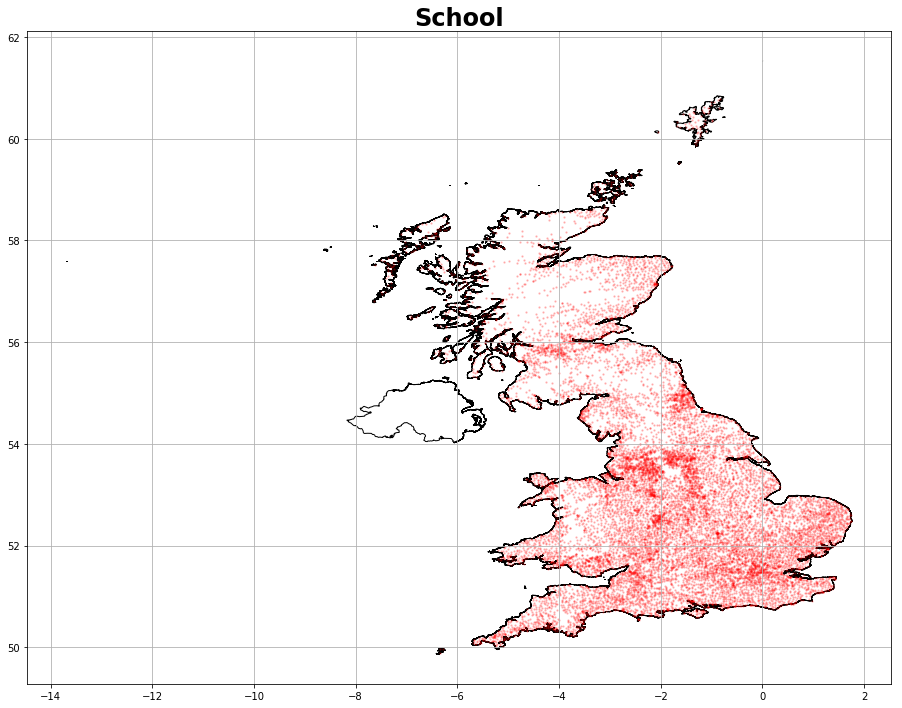

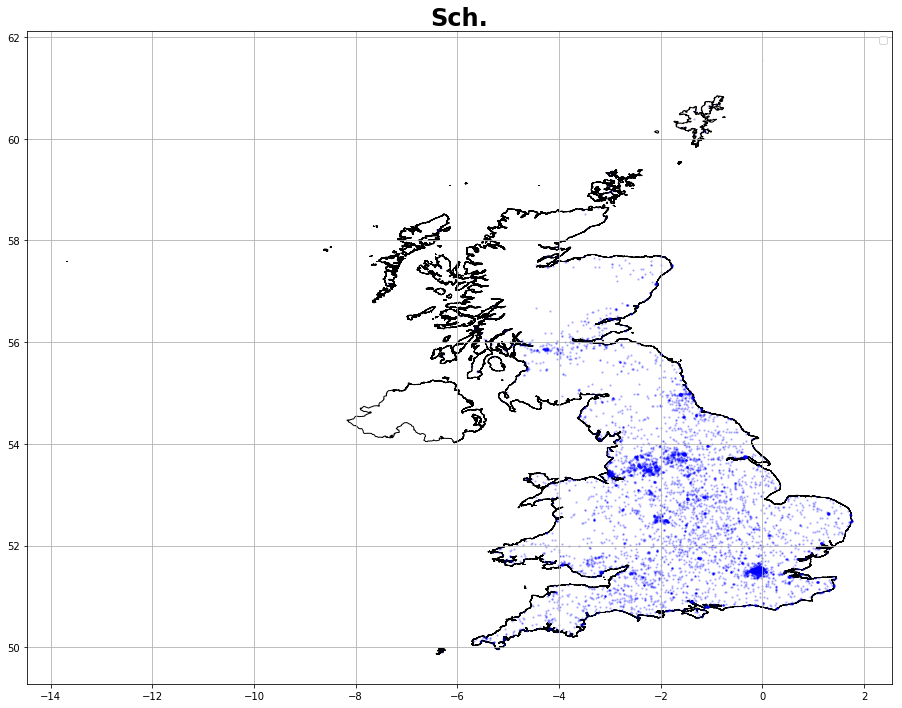

In [9]:
list_colors = ["r", "b", "g", "c", "m"]

for igrp in range(len(lats2plot)):
    geometry = [Point(xy) for xy in zip(lons2plot[igrp], lats2plot[igrp])]
    gdf = GeoDataFrame(geometry=geometry)
    gdf.plot(ax=world.plot(figsize=(20, 12), edgecolor='k', color='none'), 
             marker='o', 
             color=list_colors[igrp], 
             markersize=2,
             alpha=0.2
            )
    plt.title(list_of_selected_text[igrp], size=24, weight='bold')
    #plt.xlim(-6, -2)
    plt.grid()
plt.legend()
plt.show()

### Text strings plotted together

/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:3215: MatplotlibDeprecationWarning: 
The `xmin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `left` instead.
  alternative='`left`', obj_type='argument')


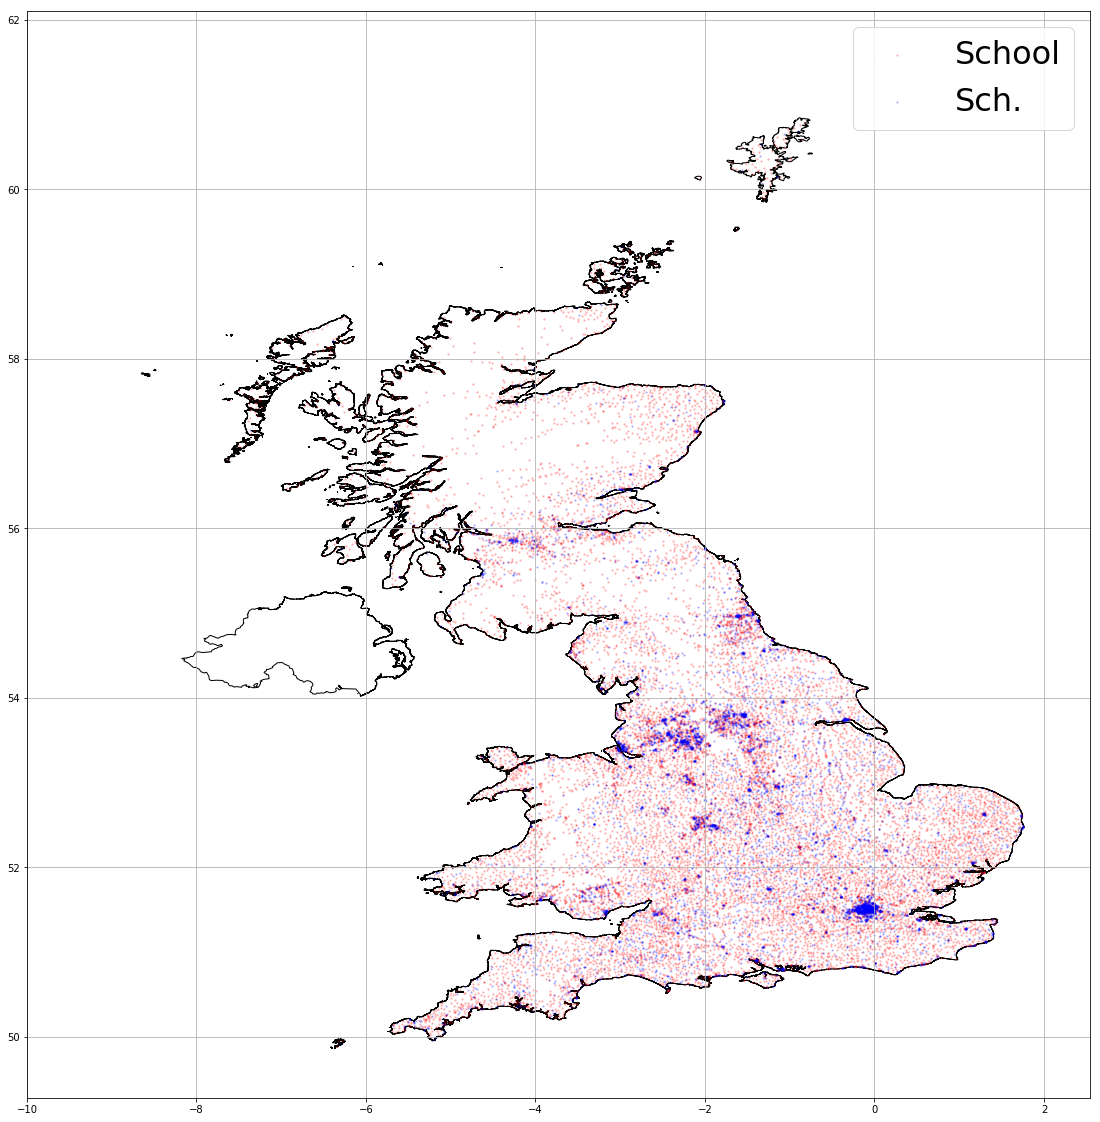

In [10]:
list_colors = ["r", "b", "g", "c", "m"]

fig, ax = plt.subplots(1, 1, figsize=(20, 20))

world.plot(ax=ax, edgecolor='k', color='none')

for igrp in range(len(lats2plot)):
    geometry = [Point(xy) for xy in zip(lons2plot[igrp], lats2plot[igrp])]
    gdf = GeoDataFrame(geometry=geometry)
    gdf.plot(ax=ax, 
             marker='o', 
             color=list_colors[igrp], 
             markersize=2,
             label=list_of_selected_text[igrp],
             alpha=0.2
            )
plt.xlim(xmin=-10)
plt.grid()
plt.legend(prop={'size': 32})
plt.show()

### Simple plot (no projection)

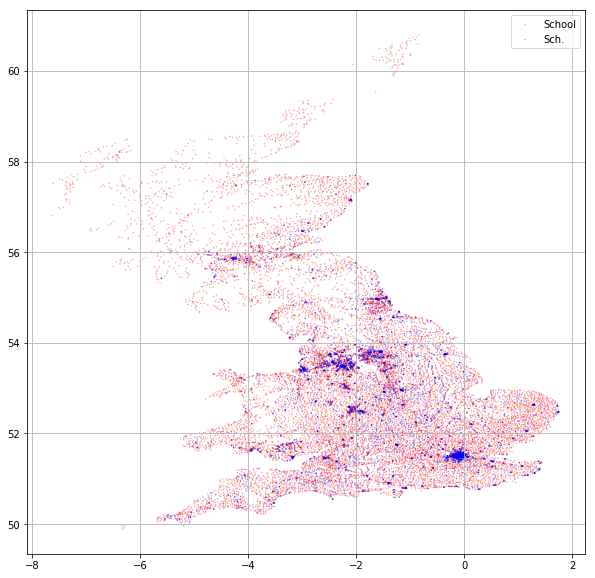

In [11]:
list_colors = ["r", "b", "g", "c", "m"]
plt.figure(figsize=(10, 10))

for igrp in range(len(lats2plot)):
    plt.scatter(np.array(lons2plot[igrp]), 
            np.array(lats2plot[igrp]), 
            c=list_colors[igrp],
            s=2,
            edgecolors='none',
            alpha=0.4,
            label=list_of_selected_text[igrp])
plt.grid()
plt.legend()
plt.show()

No handles with labels found to put in legend.


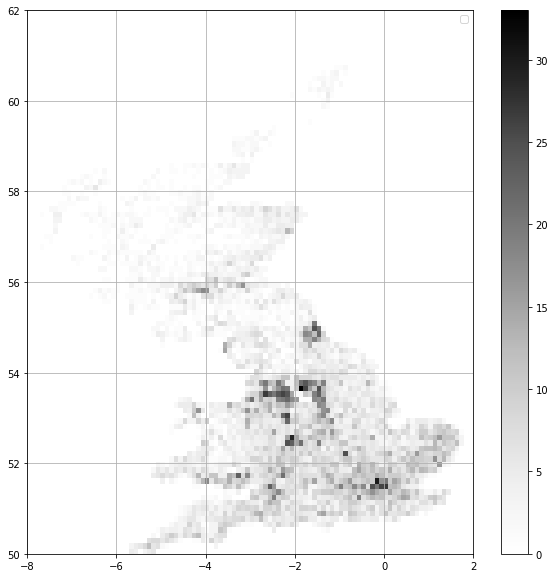

In [12]:
list_colors = ["r", "b", "g", "c", "m"]
plt.figure(figsize=(10, 10))

igrp = 0
plt.hist2d(np.array(lons2plot[igrp]), 
           np.array(lats2plot[igrp]),
           bins=(100, 100),
           range=[[-8, 2], [50, 62]],
           cmap="Greys",
           cmin=0,
           cmax=100
          )
plt.grid()
plt.legend()
plt.colorbar()
plt.show()

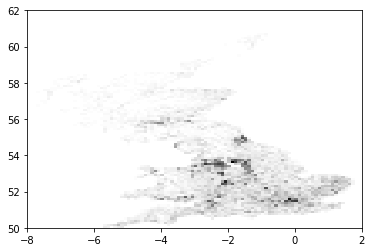

In [13]:
hist_map = plt.hist2d(np.array(lons2plot[igrp]), np.array(lats2plot[igrp]),
           bins=(100, 100),
           range=[[-8, 2], [50, 62]],
           cmap="Greys",
           cmin=0,
           cmax=100
          )

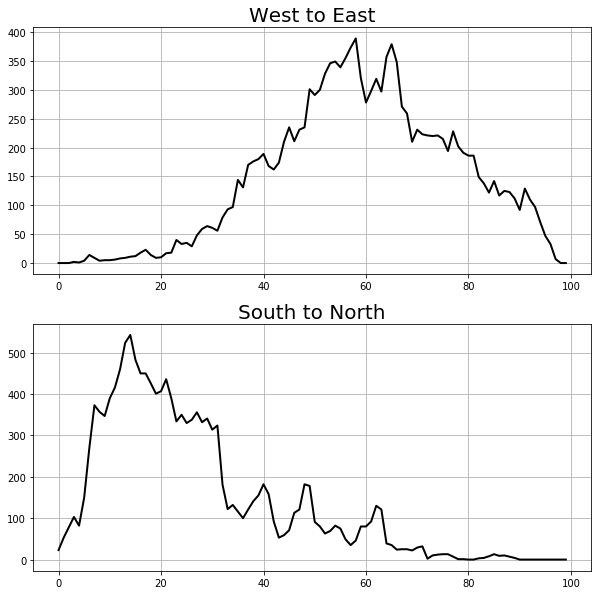

In [14]:
plt.figure(figsize=(10, 10))
plt.subplot(2, 1, 1)
plt.plot(hist_map[0].sum(axis=1), lw=2, c='k')
plt.title("West to East", size=20)
plt.grid()

plt.subplot(2, 1, 2)
plt.plot(hist_map[0].sum(axis=0), lw=2, c='k')
plt.title("South to North", size=20)
plt.grid()